# Image Data Augmentation and Normalization Notebook


This notebook will run you through a real world example of image data augmentation and normalization. We will perform these techniques on CIFAR10, a lightweight 10-class image classification dataset commonly used for benchmarking performance. We will then run our augmented dataset through VGG11, a shorter variant of the VGG series of ConvNets that were state of the art circa 2014 and still serve as a reasonable educational example of a relatively straightforward ConvNet.

As a side note, if your computer doesn't have GPU support, I would highly recommend running this on Google Colab, as you can change the runtime to use GPU there. Otherwise, the last section of the notebook will take multiple hours to run, so you can just skip it. 

Let's first import some libraries. 

In [15]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import numpy as np

In addition, let's define some helpful tools and models. We will do all the heavy work of writing the neural net model definition, loading the dataset, and the training pipeline, as well as some visualization tools. 



In [16]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

def test():
    net = VGG('VGG11')
    x = torch.randn(2,3,32,32)
    y = net(x)
    print(y.size())



In [17]:
test()

torch.Size([2, 10])


In [18]:
def loadData(transform, train, batch_size):

  dir = './data/train' if train else './data/val'
  dataset = torchvision.datasets.CIFAR10(dir, 
                                             transform = transform,
                                             train = train, 
                                             download=True)

  loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=train)
  return loader

In [19]:
def train(net, criterion, epoch, optimizer, train_loader):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.cuda(), targets.cuda() #comment out if no cuda
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

    print('Training Loss: %.3f | Acc: %.3f%% (%d/%d)'  
            % (train_loss/(batch_idx+1), 
            100.*float(correct)/float(total), correct, total))
    
    return train_loss / (batch_idx+1)

def val(net, criterion, epoch, optimizer, val_loader, best_acc):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(val_loader)):
        inputs, targets = inputs.cuda(), targets.cuda() #comment out if no cuda
        with torch.no_grad():
            inputs, targets = Variable(inputs), Variable(targets)
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

    print('Validation Loss: %.3f | Acc: %.3f%% (%d/%d)'  
            % (test_loss/(batch_idx+1), 
            100.*float(correct)/float(total), correct, total))

    acc = 100.*float(correct)/float(total)
    if acc > best_acc:
        best_acc = acc
    return test_loss / (batch_idx+1)

In [20]:
def runTraining(train_transform, val_transform):
    #load data
    print('loading data...')

    train_loader = loadData(train_transform, True, 128)
    val_loader = loadData(val_transform, False, 128)
    
    #set up net
    print('setting up net...')
    net = VGG('VGG11')
    
    #set up cuda, comment out if no cuda
    print('setting up cuda...')
    net.cuda()
    net = nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

    #set up training
    print('setting up training...')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
            net.parameters(), 
            lr=1e-2, 
            momentum=0.9, 
            weight_decay=1e-4) #can be changed in optional part
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                                               milestones=[4], gamma=0.1) #can be changed in optional part

    start_epoch = 0
    max_epoch = 10 #can be changed in optional part
    best_acc = 0

    #run one round of inference before beginning testing
    print('running pre-training inference...')
    best_acc = val(net, criterion, start_epoch, optimizer, val_loader, best_acc)

    #training
    print('starting training...')
    start_epoch += 1
    max_epoch += 1
    train_losses = []
    val_losses = []
    for epoch in range(start_epoch, max_epoch):
        train_loss = train(net, criterion, epoch, optimizer, train_loader)
        scheduler.step()
        val_loss = val(net, criterion, epoch, optimizer, val_loader, best_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    
    return train_losses, val_losses


In [21]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [22]:
def showKImgs(transform, k):
  # get some random training images
  loader = loadData(transform, True, k)

  dataiter = iter(loader)
  images, labels = dataiter.next()

  # create grid of images
  img_grid = torchvision.utils.make_grid(images)

  # show images
  matplotlib_imshow(img_grid, one_channel=False)


Let's first define a dummy transform. This transform performs no augmentation except for the necessary task of converting the PIL images to tensors.

In [23]:
val_transform = transforms.Compose([
        transforms.ToTensor(),
    ])
train_transform = transforms.Compose([
        transforms.ToTensor(),
    ])


Use the provided functions to visualize the first couple of images in the training dataset. We will be using the CIFAR10 dataset (this is already written for you, don't worry about it). 

Files already downloaded and verified


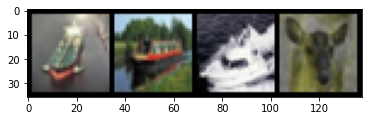

In [24]:
#begin student code
showKImgs(train_transform, 4)
#end student code 

Here is the pytorch transforms documentation: https://pytorch.org/docs/stable/torchvision/transforms.html. Image transforms such as crops, flips, shifts, etc. should only ever be applied to the train set, as applying them to the val set as well defeats the purpose of augmenting the dataset in the first place. Try to use one of the functions in there to perform a random horizontal flip of the images, then visualize it. 

Files already downloaded and verified


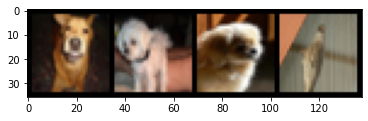

In [25]:
#begin student code
train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])
showKImgs(train_transform, 4)
#end student code

In addition to image transforms, we may want to normalize or standardize the images. These need to be applied to both the val and train sets. To normalize, we first need to figure out the mean and stddev for each rgb channel across the entire dataset. Try calculating the mean and stddev for CIFAR10 first and print them out. 

Hint: Moving the raw data onto tensors scales the data from 0-255 to 0-1, so make sure to account for that. 

In [26]:
#begin student code
train_data = datasets.CIFAR10('./data/train', train=True, download=True)
print("shape: ", train_data.data.shape)

std = train_data.data.std((0, 1, 2)) / 255
mean = train_data.data.mean((0, 1, 2)) / 255
print("mean: ", mean)
print("std: ", std)
#end student code

Files already downloaded and verified
shape:  (50000, 32, 32, 3)
mean:  [0.49139968 0.48215841 0.44653091]
std:  [0.24703223 0.24348513 0.26158784]


Now use your calculated mean and stddev to normalize the dataset using the function from transforms, and visualize the first couple of images. As a sanity check, you can look up the mean and stddev for CIFAR10 according to this thread: https://github.com/facebookarchive/fb.resnet.torch/issues/180

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


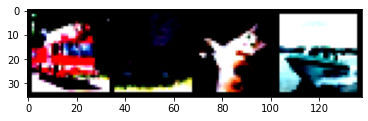

In [27]:
#begin student code
train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
showKImgs(train_transform, 4)
#end student code

As a baseline, we will see how well VGG performs on CIFAR10 without any augmentation. Write a dummy transform with no augmentation and use the given functions to run the training (this should take roughly 30 seconds per epoch for a total of roughly 5 minutes).

In [28]:
#begin student code
val_transform = transforms.Compose([
        transforms.ToTensor(),
    ])
train_transform = transforms.Compose([
        transforms.ToTensor(),
    ])
train_losses, val_losses = runTraining(train_transform, val_transform)
#end student code

loading data...
Files already downloaded and verified
Files already downloaded and verified
setting up net...
setting up cuda...
setting up training...
running pre-training inference...



Validation Loss: 2.303 | Acc: 10.000% (1000/10000)
starting training...

Epoch: 1



Training Loss: 1.233 | Acc: 55.890% (27945/50000)



Validation Loss: 1.546 | Acc: 51.200% (5120/10000)

Epoch: 2



Training Loss: 0.757 | Acc: 73.326% (36663/50000)



Validation Loss: 0.854 | Acc: 70.800% (7080/10000)

Epoch: 3



Training Loss: 0.574 | Acc: 80.146% (40073/50000)



Validation Loss: 0.770 | Acc: 73.530% (7353/10000)

Epoch: 4



Training Loss: 0.439 | Acc: 84.708% (42354/50000)



Validation Loss: 0.835 | Acc: 72.930% (7293/10000)

Epoch: 5



Training Loss: 0.190 | Acc: 93.720% (46860/50000)



Validation Loss: 0.515 | Acc: 83.570% (8357/10000)

Epoch: 6



Training Loss: 0.115 | Acc: 96.440% (48220/50000)



Validation Loss: 0.545 | Acc: 83.660% (8366/10000)

Epoch: 7



Training Loss: 0.073 | Acc: 97.994% (48997/50000)



Validation Loss: 0.592 | Acc: 83.530% (8353/10000)

Epoch: 8



Training Loss: 0.041 | Acc: 99.022% (49511/50000)



Validation Loss: 0.637 | Acc: 83.200% (8320/10000)

Epoch: 9



Training Loss: 0.023 | Acc: 99.626% (49813/50000)



Validation Loss: 0.672 | Acc: 83.560% (8356/10000)

Epoch: 10



Training Loss: 0.012 | Acc: 99.878% (49939/50000)



Validation Loss: 0.708 | Acc: 83.300% (8330/10000)


Plot the train and val losses per epoch using a line graph. You can use this as a reference: https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.plot.html

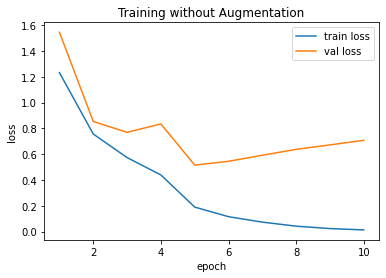

In [33]:
#begin student code
epochs = [i+1 for i in range(10)]

plt.plot(epochs, train_losses, label="train loss")
plt.plot(epochs, val_losses, label="val loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("Training without Augmentation")
plt.show()

#end student code

You should have gotten roughly 0.7 val loss. However, the trianing loss is almost zero, which means we have saturated performance on the training set. This is a classic example of overfitting, as our train loss is vastly lower than our val loss. After around epoch 5, we actually get much worse as we keep training because our model fits more and more towards the training data, which is not robust enough.

Now, you will compose your own train_transform function and use it to train with your augmented dataset. Fill in the following cell and run the training (this will take a little longer, as applying the transforms for each image takes up some time as well).

You can look at some preprocessing practices in section 4.1 of this classic paper: https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

as well as section 3.4 of this other classic paper:
 https://arxiv.org/pdf/1512.03385.pdf

Hint: check to make sure the final size of your images after the transform is done matches the expected input size from CIFAR10.

The pytorch transforms documentation for your convenience: https://pytorch.org/docs/stable/torchvision/transforms.html

In [34]:
#begin student code
val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
final_train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
final_train_losses, final_val_losses = runTraining(final_train_transform, val_transform)
#end student code

loading data...
Files already downloaded and verified
Files already downloaded and verified
setting up net...
setting up cuda...
setting up training...
running pre-training inference...



Validation Loss: 2.303 | Acc: 10.000% (1000/10000)
starting training...

Epoch: 1



Training Loss: 1.425 | Acc: 48.840% (24420/50000)



Validation Loss: 1.260 | Acc: 58.000% (5800/10000)

Epoch: 2



Training Loss: 0.944 | Acc: 66.588% (33294/50000)



Validation Loss: 1.113 | Acc: 63.910% (6391/10000)

Epoch: 3



Training Loss: 0.772 | Acc: 72.986% (36493/50000)



Validation Loss: 0.783 | Acc: 73.880% (7388/10000)

Epoch: 4



Training Loss: 0.669 | Acc: 76.760% (38380/50000)



Validation Loss: 0.843 | Acc: 71.910% (7191/10000)

Epoch: 5



Training Loss: 0.490 | Acc: 83.004% (41502/50000)



Validation Loss: 0.512 | Acc: 82.220% (8222/10000)

Epoch: 6



Training Loss: 0.452 | Acc: 84.242% (42121/50000)



Validation Loss: 0.500 | Acc: 83.040% (8304/10000)

Epoch: 7



Training Loss: 0.432 | Acc: 84.854% (42427/50000)



Validation Loss: 0.474 | Acc: 83.960% (8396/10000)

Epoch: 8



Training Loss: 0.413 | Acc: 85.652% (42826/50000)



Validation Loss: 0.469 | Acc: 84.080% (8408/10000)

Epoch: 9



Training Loss: 0.400 | Acc: 86.156% (43078/50000)



Validation Loss: 0.474 | Acc: 84.190% (8419/10000)

Epoch: 10



Training Loss: 0.383 | Acc: 86.756% (43378/50000)



Validation Loss: 0.462 | Acc: 84.510% (8451/10000)


Again, plot the train and val losses per epoch using a line graph. You can use this as a reference: https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.plot.html


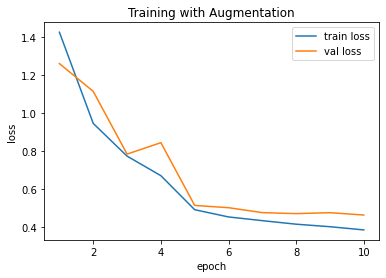

In [35]:
#begin student code
epochs = [i+1 for i in range(10)]

plt.plot(epochs, final_train_losses, label="train loss")
plt.plot(epochs, final_val_losses, label="val loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("Training with Augmentation")
plt.show()

#end student code

You should have gotten a better val loss, around 0.5 or so. In addition, the final train loss is still also around 0.5 or so. This means our model has not saturated train performance yet, so if we were to continue training it, it has room for improvement, which should also improve the val accuracy (we won't make you sit through this, as fully training out neural networks for real life performance takes many epochs and compute hours, and the payoffs are diminishing in return the longer you train). In short, our model is a lot less weak to overfitting on the training data.

As an optional extra exercise, the canonical performance for VGG11 on CIFAR10 is around 91%. See if you can play around with different data transform options to come somewhere near that performance. You will probably need to tune some hyperparameters as well, such as the LRScheduler, LR, weight decay, epochs, etc.